# Grid CRFs

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from time import time

from pystruct.inference import inference_dispatch, compute_energy
from pystruct.utils import make_grid_edges

size = 20
n_states = 5

rnd = np.random.RandomState(2)
x = rnd.normal(size=(size, size, n_states))
pairwise = np.eye(n_states)
edges = make_grid_edges(x)
unaries = x.reshape(-1, n_states)

unaries.shape

(400, 5)

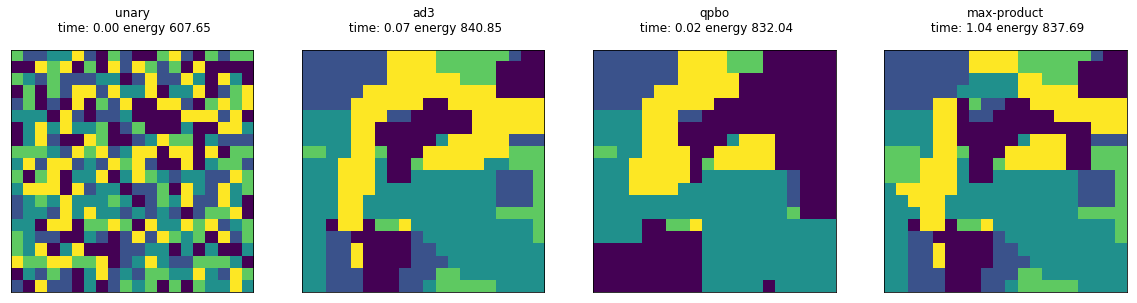

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for a, inference_method in zip(ax, [ 'unary', 'ad3', 'qpbo', 'max-product']):
    start = time()
    y = inference_dispatch(unaries, pairwise, edges,
                           inference_method=inference_method)
    took = time() - start
    a.matshow(y.reshape(size, size))
    energy = compute_energy(unaries, pairwise, edges, y)
    a.set_title(str(inference_method) + "\n time: %.2f energy %.2f" % (took, energy))
    a.set_xticks(())
    a.set_yticks(())
plt.show()

## Stereo Vision

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyqpbo import alpha_expansion_grid


def stereo_unaries(img1, img2):
    differences = []
    max_disp = 8
    for disp in np.arange(max_disp):
        if disp == 0:
            diff = np.sum((img1 - img2) ** 2, axis=2)
        else:
            diff = np.sum((img1[:, 2 * disp:, :] - img2[:, :-2 * disp, :]) **
                    2, axis=2)
        if disp != max_disp - 1:
            diff = diff[:, max_disp - disp - 1:disp - max_disp + 1]
        differences.append(diff)
    return np.dstack(differences).copy("C")


img1 = np.asarray(Image.open("scene1.row3.col1.ppm")) / 255.
img2 = np.asarray(Image.open("scene1.row3.col2.ppm")) / 255.
unaries = (stereo_unaries(img1, img2) * 100).astype(np.int32)
n_disps = unaries.shape[2]

#newshape = unaries.shape[:2]
potts_cut = alpha_expansion_grid(unaries, -5 * np.eye(n_disps,
    dtype=np.int32), n_iter=5)
x, y = np.ogrid[:n_disps, :n_disps]
one_d_topology = np.abs(x - y).astype(np.int32).copy("C")
one_d_cut = alpha_expansion_grid(unaries, 5 * one_d_topology, n_iter=5)

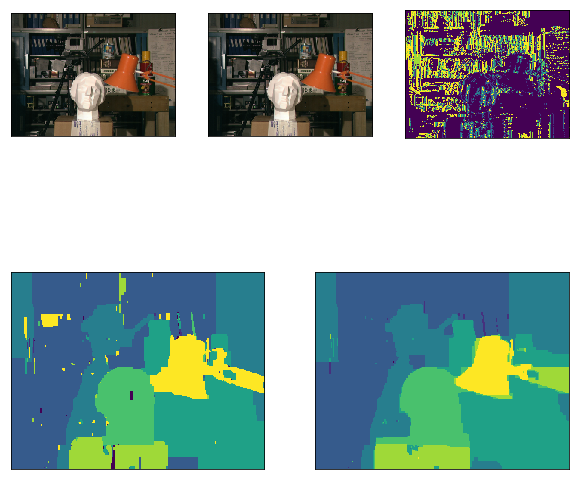

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(231, xticks=(), yticks=())
plt.imshow(img1)
plt.subplot(232, xticks=(), yticks=())
plt.imshow(img1)
plt.subplot(233, xticks=(), yticks=())
plt.imshow(np.argmax(unaries, axis=2), interpolation='nearest')
plt.subplot(223, xticks=(), yticks=())
plt.imshow(potts_cut, interpolation='nearest')
plt.subplot(224, xticks=(), yticks=())
plt.imshow(one_d_cut, interpolation='nearest')
plt.show()

# Learning Pairwise Interactions

In [17]:
im.shape

(9, 9, 3)

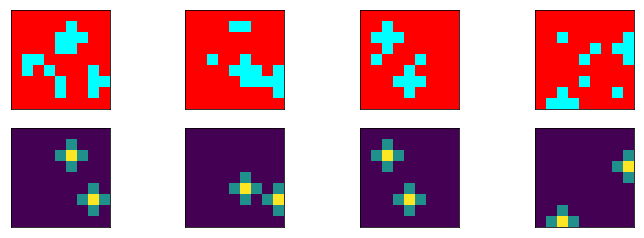

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from pystruct.models import GridCRF
import pystruct.learners as ssvm
from pystruct.datasets import generate_crosses_explicit
from pystruct.utils import expand_sym


X, Y = generate_crosses_explicit(n_samples=50, noise=10)
fig, axes = plt.subplots(2, 4, figsize=(12, 4),
                        subplot_kw={'xticks':(), 'yticks':()})
for im, ax in zip(X, axes[0]):
    ax.imshow(im)
for im, ax in zip(Y, axes[1]):
    ax.imshow(im)

In [14]:
crf = GridCRF(neighborhood=4)
clf = ssvm.OneSlackSSVM(model=crf, C=100, inference_cache=100,
                        tol=.1)
clf.fit(X, Y)
Y_pred = np.array(clf.predict(X))
print("overall accuracy (training set): %f" % clf.score(X, Y))

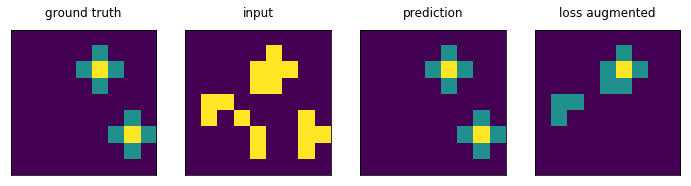

In [22]:

# plot one example
x, y, y_pred = X[0], Y[0], Y_pred[0]
y_pred = y_pred.reshape(x.shape[:2])
fig, plots = plt.subplots(1, 4, figsize=(12, 4))
plots[0].matshow(y)
plots[0].set_title("ground truth")
plots[1].matshow(np.argmax(x, axis=-1))
plots[1].set_title("input")
plots[2].matshow(y_pred)
plots[2].set_title("prediction")
loss_augmented = clf.model.loss_augmented_inference(x, y, clf.w)
loss_augmented = loss_augmented.reshape(y.shape)
plots[3].matshow(loss_augmented)
plots[3].set_title("loss augmented")
for p in plots:
    p.set_xticks(())
    p.set_yticks(())

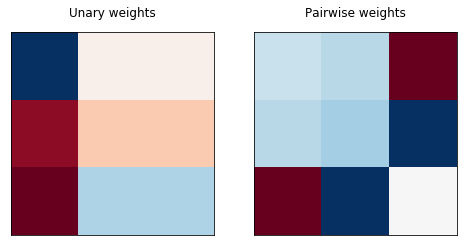

In [24]:

# visualize weights
w_un = clf.w[:3 * 3].reshape(3, 3)
# decode the symmetric pairwise potential
w_pw = expand_sym(clf.w[3 * 3:])

fig, plots = plt.subplots(1, 2, figsize=(8, 4))
plots[0].matshow(w_un, cmap=plt.cm.RdBu, vmin=-5, vmax=5)
plots[0].set_title("Unary weights")
plots[1].matshow(w_pw, cmap=plt.cm.RdBu, vmin=-5, vmax=5)
plots[1].set_title("Pairwise weights")
for p in plots:
    p.set_xticks(())
    p.set_yticks(())

# Edge Features
This example uses the snake dataset introduced in
Nowozin, Rother, Bagon, Sharp, Yao, Kohli: Decision Tree Fields ICCV 2011

This dataset is specifically designed to require the pairwise interaction terms
to be conditioned on the input, in other words to use non-trival edge-features.

The task is as following: a "snake" of length ten wandered over a grid. For
each cell, it had the option to go up, down, left or right (unless it came from
there). The input consists of these decisions, while the desired output is an
annotation of the snake from 0 (head) to 9 (tail).  See the plots for an
example.

As input features we use a 3x3 window around each pixel (and pad with background
where necessary). We code the five different input colors (for up, down, left, right,
background) using a one-hot encoding. This is a rather naive approach, not using any
information about the dataset (other than that it is a 2d grid).

The task can not be solved using the simple DirectionalGridCRF - which can only
infer head and tail (which are also possible to infer just from the unary
features). If we add edge-features that contain the features of the nodes that are
connected by the edge, the CRF can solve the task.

From an inference point of view, this task is very hard.  QPBO move-making is
not able to solve it alone, so we use the relaxed AD3 inference for learning.

PS: This example runs a bit (5 minutes on 12 cores, 20 minutes on one core for me).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score

from pystruct.learners import OneSlackSSVM
from pystruct.datasets import load_snakes
from pystruct.utils import make_grid_edges, edge_list_to_features
from pystruct.models import EdgeFeatureGraphCRF


def one_hot_colors(x):
    x = x / 255
    flat = np.dot(x.reshape(-1, 3), 2 ** np.arange(3))
    one_hot = label_binarize(flat, classes=[1, 2, 3, 4, 6])
    return one_hot.reshape(x.shape[0], x.shape[1], 5)


def neighborhood_feature(x):
    """Add a 3x3 neighborhood around each pixel as a feature."""
    # we could also use a four neighborhood, that would work even better
    # but one might argue then we are using domain knowledge ;)
    features = np.zeros((x.shape[0], x.shape[1], 5, 9))
    # position 3 is background.
    features[:, :, 3, :] = 1
    features[1:, 1:, :, 0] = x[:-1, :-1, :]
    features[:, 1:, :, 1] = x[:, :-1, :]
    features[:-1, 1:, :, 2] = x[1:, :-1, :]
    features[1:, :, :, 3] = x[:-1, :, :]
    features[:-1, :-1, :, 4] = x[1:, 1:, :]
    features[:-1, :, :, 5] = x[1:, :, :]
    features[1:, :-1, :, 6] = x[:-1, 1:, :]
    features[:, :-1, :, 7] = x[:, 1:, :]
    features[:, :, :, 8] = x[:, :, :]
    return features.reshape(x.shape[0] * x.shape[1], -1)


def prepare_data(X):
    X_directions = []
    X_edge_features = []
    for x in X:
        # get edges in grid
        right, down = make_grid_edges(x, return_lists=True)
        edges = np.vstack([right, down])
        # use 3x3 patch around each point
        features = neighborhood_feature(x)
        # simple edge feature that encodes just if an edge is horizontal or
        # vertical
        edge_features_directions = edge_list_to_features([right, down])
        # edge feature that contains features from the nodes that the edge connects
        edge_features = np.zeros((edges.shape[0], features.shape[1], 4))
        edge_features[:len(right), :, 0] = features[right[:, 0]]
        edge_features[:len(right), :, 1] = features[right[:, 1]]
        edge_features[len(right):, :, 0] = features[down[:, 0]]
        edge_features[len(right):, :, 1] = features[down[:, 1]]
        edge_features = edge_features.reshape(edges.shape[0], -1)
        X_directions.append((features, edges, edge_features_directions))
        X_edge_features.append((features, edges, edge_features))
    return X_directions, X_edge_features

In [ ]:
snakes = load_snakes()
X_train, Y_train = snakes['X_train'], snakes['Y_train']

X_train = [one_hot_colors(x) for x in X_train]
Y_train_flat = [y_.ravel() for y_ in Y_train]

X_train_directions, X_train_edge_features = prepare_data(X_train)

inference = 'qpbo'
# first, train on X with directions only:
crf = EdgeFeatureGraphCRF(inference_method=inference)
ssvm = OneSlackSSVM(crf, inference_cache=50, C=.1, tol=.1, max_iter=100,
                    n_jobs=1)
ssvm.fit(X_train_directions, Y_train_flat)

In [ ]:
# Evaluate using confusion matrix.
# Clearly the middel of the snake is the hardest part.
X_test, Y_test = snakes['X_test'], snakes['Y_test']
X_test = [one_hot_colors(x) for x in X_test]
Y_test_flat = [y_.ravel() for y_ in Y_test]
X_test_directions, X_test_edge_features = prepare_data(X_test)
Y_pred = ssvm.predict(X_test_directions)
print("Results using only directional features for edges")
print("Test accuracy: %.3f"
      % accuracy_score(np.hstack(Y_test_flat), np.hstack(Y_pred)))
print(confusion_matrix(np.hstack(Y_test_flat), np.hstack(Y_pred)))

In [ ]:
print("Please be patient. Learning will take 5-20 minutes.")

# now, use more informative edge features:
crf = EdgeFeatureGraphCRF(inference_method=inference)
ssvm = OneSlackSSVM(crf, inference_cache=50, C=.1, tol=.1, switch_to='ad3',
                    n_jobs=-1)
ssvm.fit(X_train_edge_features, Y_train_flat)
Y_pred2 = ssvm.predict(X_test_edge_features)
print("Results using also input features for edges")
print("Test accuracy: %.3f"
      % accuracy_score(np.hstack(Y_test_flat), np.hstack(Y_pred2)))
print(confusion_matrix(np.hstack(Y_test_flat), np.hstack(Y_pred2)))

In [ ]:
# plot stuff
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(snakes['X_test'][0], interpolation='nearest')
axes[0, 0].set_title('Input')
y = Y_test[0].astype(np.int)
bg = 2 * (y != 0)  # enhance contrast
axes[0, 1].matshow(y + bg, cmap=plt.cm.Greys)
axes[0, 1].set_title("Ground Truth")
axes[1, 0].matshow(Y_pred[0].reshape(y.shape) + bg, cmap=plt.cm.Greys)
axes[1, 0].set_title("Prediction w/o edge features")
axes[1, 1].matshow(Y_pred2[0].reshape(y.shape) + bg, cmap=plt.cm.Greys)
axes[1, 1].set_title("Prediction with edge features")
for a in axes.ravel():
    a.set_xticks(())
    a.set_yticks(())
plt.show()